#### <font color='blue'> Import relevant modules </font>

In [4]:
# data manipulation
import pandas as pd
import numpy as np
import os,math,timeit,time
import matplotlib.pyplot as plt
import seaborn as sns

# data pre-post processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

# data modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.externals import joblib # to save and re-use the created best model for later use

# neural network
from keras import Sequential,models,regularizers,layers
from keras.models import load_model
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# import class with an alias
import ProcessClass as pc

#### <font color ='green'> Define Main Processing Class and some useful functions</font>

In [5]:
def F1_score(model_obj,X,y,nn='N',n=10):
    '''Function to calculate the F1 score averaged over a n fold CV set'''
    SEED=42    
    mean_f1 = 0.0
    n_cv=0
    skf = StratifiedKFold(n_splits=n,random_state=SEED,shuffle =True)
    
    if nn=='Y':        
        for train_index, test_index in skf.split(X, y):
            n_cv+=1
            X_train, X_cv = X[train_index], X[test_index] 
            y_train, y_cv = y[train_index], y[test_index]
            #fit and predict the target labels for a neural network   
            #model_obj.fit(X_train, y_train,batch_size=10, epochs=5)
            # patient early stopping
            es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=0)
            mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
            # fit model
            if n_cv>1:
                model_obj = load_model('best_model.h5')
            history = model_obj.fit(X_train, y_train, validation_data=(X_cv, y_cv), epochs=10, callbacks=[es,mc])
            # evaluate the model
            _, train_acc = model_obj.evaluate(X_train, y_train, verbose=0)
            _, test_acc = model_obj.evaluate(X_cv, y_cv, verbose=0)
            print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
            # plot training history
            plt.plot(history.history['loss'], label='train')
            plt.plot(history.history['val_loss'], label='test')
            plt.legend()
            plt.show()
            
            preds = model_obj.predict(X_cv)
            preds = (preds>0.5).astype(int)            

            # compute f1 metric for this CV fold
            f1_score = metrics.f1_score(y_cv, preds,average='macro')
            print("\n Best F1 score for CV fold no:{} was:{}\n".format(n_cv,f1_score))
            mean_f1 += f1_score
        # load the saved model
        model_obj = load_model('best_model.h5')
        # evaluate the model
        _, train_acc = model_obj.evaluate(X_train, y_train, verbose=0)
        _, test_acc = model_obj.evaluate(X_cv, y_cv, verbose=0)
        print('\n Best Model has the following scores :\n')
        print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    else:
        for train_index, test_index in skf.split(X, y): 
            n_cv+=1
            X_train, X_cv = X[train_index], X[test_index] 
            y_train, y_cv = y[train_index], y[test_index]
            #fit and predict the target labels    
            model_obj.fit(X_train, y_train)
            preds = model_obj.predict(X_cv)     

            # compute f1 metric for this CV fold
            f1_score = metrics.f1_score(y_cv, preds,average='macro')  
            print("\n F1 score for CV fold no:{} was:{}\n".format(n_cv,f1_score))
            mean_f1 += f1_score
    return  (mean_f1/n),model_obj

> Stage 1: <font color = 'blue'> Load and preprocess data </font>

In [6]:
# basic pre-processing of raw data, load,dedupe, impute missing values, encode categories and scale continuous features
trainfile = 'train.csv'
target_col = 'm13'
uniquekey = 'loan_id'

testfile = 'test.csv'
predictor = 'loan_id'

#enc='onehot'
enc='label'

# process train file
print("\n ########## Processing Training file now ########\n")
trainData = pc.Process(trainfile)

#feature engineering - create new feature from existing features(optional)
traindf = trainData.getDF()

traindf['daily_unpaid_bal'] = traindf['unpaid_principal_bal']/traindf['loan_term']
#traindf['tot_delinq_days'] = traindf.iloc[:,16:-1].sum(axis=1) # monthly delinquencies
traindf['avg_credit_score'] = (traindf['borrower_credit_score']+traindf['co-borrower_credit_score'])/traindf['number_of_borrowers']
#traindf['insurance_percent'].where(traindf['insurance_type']==0,inplace=True)

#traindf['origination_date'] = pd.to_datetime(traindf['origination_date']).dt.strftime('%Y-%m-%d')
#traindf['first_payment_date'] = pd.to_datetime('01/'+traindf['first_payment_date'],dayfirst=True).dt.strftime('%Y-%m-%d')
#traindf['origination_date'] = (pd.to_datetime(traindf['origination_date'])-pd.to_datetime('1970-01-01'))/ np.timedelta64(1, 'D')
#traindf['first_payment_date'] = (pd.to_datetime('01/'+traindf['first_payment_date'],dayfirst=True)-pd.to_datetime('1970-01-01'))/ np.timedelta64(1, 'D')
#traindf['days_to_first_payment'] = (pd.to_datetime('01/'+traindf['first_payment_date'],dayfirst=True)-pd.to_datetime(traindf['origination_date']))/ np.timedelta64(1, 'D')
#traindf['days_to_first_payment'] = traindf['first_payment_date'] - traindf['origination_date']

traindf.drop(['unpaid_principal_bal','loan_term','number_of_borrowers','borrower_credit_score'],1,inplace=True)

trainData.setDF(traindf)
trainData.setTargetCol(target_col)
trainData.setPredictCol(predictor)


trainData.viewMissingInfo()


trainData.cleanse_dedup(keylist=[uniquekey])
trainData.imputeNulls()
trainData.encode_cols(enc=enc)
trainData.scale_cols()
trainData.getShape()


# process test file
print("\n ########## Processing Testing file now ########\n")
#reqd_cols = [ c for c in reqd_cols if c!=target_col] # filter out the target column for testing

testData = pc.Process(testfile)

#feature engineering - create new feature from existing features(optional)
testdf = testData.getDF()

testdf['daily_unpaid_bal'] = testdf['unpaid_principal_bal']/testdf['loan_term']
#testdf['tot_delinq_days'] = testdf.iloc[:,16:-1].sum(axis=1) # monthly delinquencies
testdf['avg_credit_score'] = (testdf['borrower_credit_score']+testdf['co-borrower_credit_score'])/testdf['number_of_borrowers']
#testdf['insurance_percent'].where(testdf['insurance_type']==0,inplace=True)

#testdf['origination_date'] = pd.to_datetime(testdf['origination_date']).dt.strftime('%Y-%m-%d')
#testdf['first_payment_date'] = pd.to_datetime('01/'+testdf['first_payment_date'],dayfirst=True).dt.strftime('%Y-%m-%d')
#testdf['origination_date'] = (pd.to_datetime(testdf['origination_date'])-pd.to_datetime('1970-01-01'))/ np.timedelta64(1, 'D')
#testdf['first_payment_date'] = (pd.to_datetime('01/'+testdf['first_payment_date'],dayfirst=True)-pd.to_datetime('1970-01-01'))/ np.timedelta64(1, 'D')
#testdf['days_to_first_payment'] = (pd.to_datetime('01/'+testdf['first_payment_date'],dayfirst=True)-pd.to_datetime(testdf['origination_date']))/ np.timedelta64(1, 'D')
#testdf['days_to_first_payment'] = testdf['first_payment_date'] - testdf['origination_date']

testdf.drop(['unpaid_principal_bal','loan_term','number_of_borrowers','borrower_credit_score'],1,inplace=True)

testData.setDF(testdf)
testData.setPredictCol(predictor)

testData.viewMissingInfo()

testData.cleanse_dedup(keylist=[uniquekey])
testData.imputeNulls()
testData.encode_cols(enc=enc)
testData.scale_cols()
testData.getShape()

if enc=='onehot':
    # ensure that we train with coulmns present in both sets
    cols_req = [ c for c in trainData.getCols() if c in testData.getCols() ]
    trainData.setCols(cols_req)

traindf = trainData.getDF()
testdf = testData.getDF()


 ########## Processing Training file now ########


 Initial File loaded with total 29 columns and 116058 rows 


 Missing values information 


 no missing values found in any column 


 List of columns with missing values now : []


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 File has 25 predictor columns and 116058 observation rows 


 ########## Processing Testing file now ########


 Initial File loaded with total 28 columns and 35866 rows 


 Missing values information 


 no missing values found in any column 


 List of columns with missing values now : []


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 File has 25 predictor columns and 35866 observation rows 



In [7]:
traindf.head() # check the processed training file

,loan_id,source,financial_institution,interest_rate,origination_date,first_payment_date,loan_to_value,debt_to_income_ratio,loan_purpose,insurance_percent,...,m6,m7,m8,m9,m10,m11,m12,m13,daily_unpaid_bal,avg_credit_score
0,268055008619,1.0,1.000000,0.444444,1.0,1.000000,0.978022,0.333333,1.0,0.75,...,0.000,0.111111,0.0,0.000000,0.000000,0.000000,0.000000,1,0.083438,0.455381
1,672831657627,0.5,0.833333,0.583333,0.0,0.333333,0.725275,0.682540,0.5,0.00,...,0.000,0.000000,0.0,0.000000,0.000000,0.076923,0.000000,1,0.054088,0.457349
2,742515242108,1.0,0.944444,0.222222,0.0,0.333333,0.472527,0.507937,0.5,0.00,...,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1,0.300629,0.511811
3,601385667462,0.0,0.444444,0.555556,0.5,0.666667,0.439560,0.682540,0.5,0.00,...,0.000,0.000000,0.0,0.090909,0.083333,0.076923,0.071429,1,0.050314,0.416995
4,273870029961,0.0,0.444444,0.555556,0.5,0.666667,0.813187,0.666667,1.0,0.00,...,0.625,0.666667,0.7,0.727273,0.750000,0.769231,0.785714,1,0.045702,0.446850


In [8]:
testdf.head() # check the processed testing file

,loan_id,source,financial_institution,interest_rate,origination_date,first_payment_date,loan_to_value,debt_to_income_ratio,loan_purpose,insurance_percent,...,m5,m6,m7,m8,m9,m10,m11,m12,daily_unpaid_bal,avg_credit_score
0,1,0.5,0.055556,0.352941,0.5,0.000000,0.760870,0.351852,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214516,0.941597
1,2,0.0,0.444444,0.500000,0.5,0.000000,0.815217,0.592593,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051075,0.939809
2,3,0.5,0.444444,0.500000,0.0,0.666667,0.760870,0.611111,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029032,0.846246
3,4,0.0,0.333333,0.411765,0.5,0.000000,0.391304,0.425926,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122581,0.960072
4,5,0.0,0.055556,0.205882,0.5,0.000000,0.521739,0.203704,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.168817,0.914779


> *** <font color="green">Dimentionality reduction phase(required as we have 20+ features, some of them may be statistically irrelevant for modelling)</font> ***

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


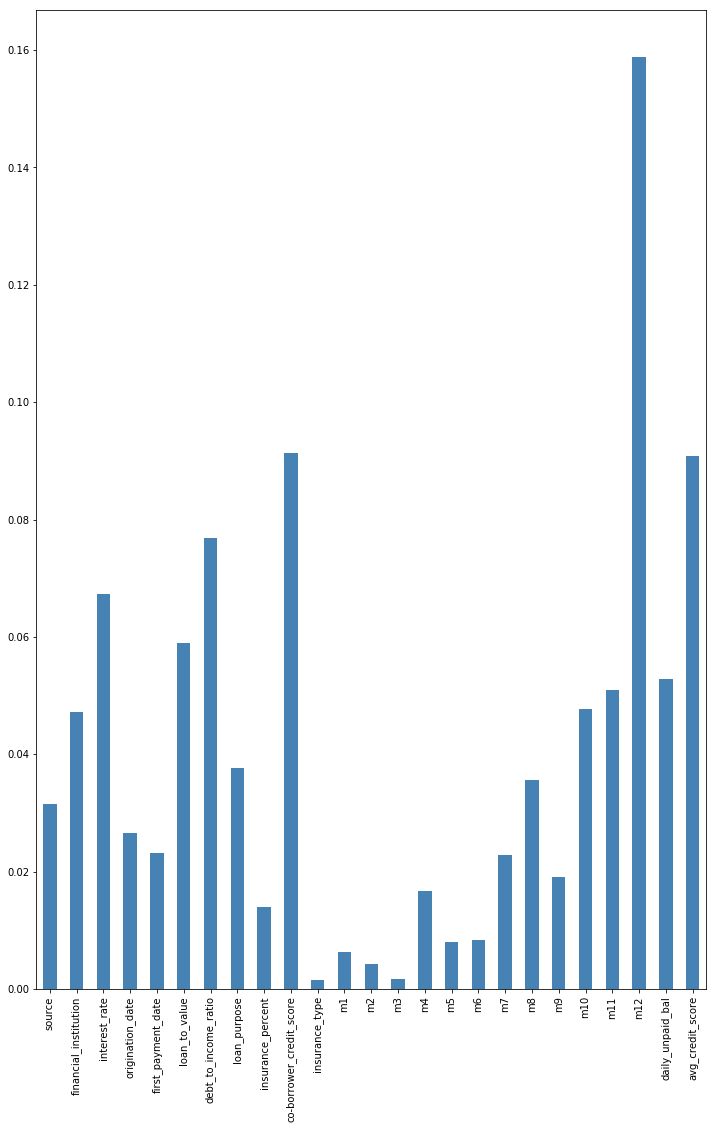

In [9]:
trainData.dropCols(uniquekey) # drop the uniquekey value as its not statistically randomly generated

# now plot a graph of feature importance and view thresholds
trainData.plot_feature_imp()

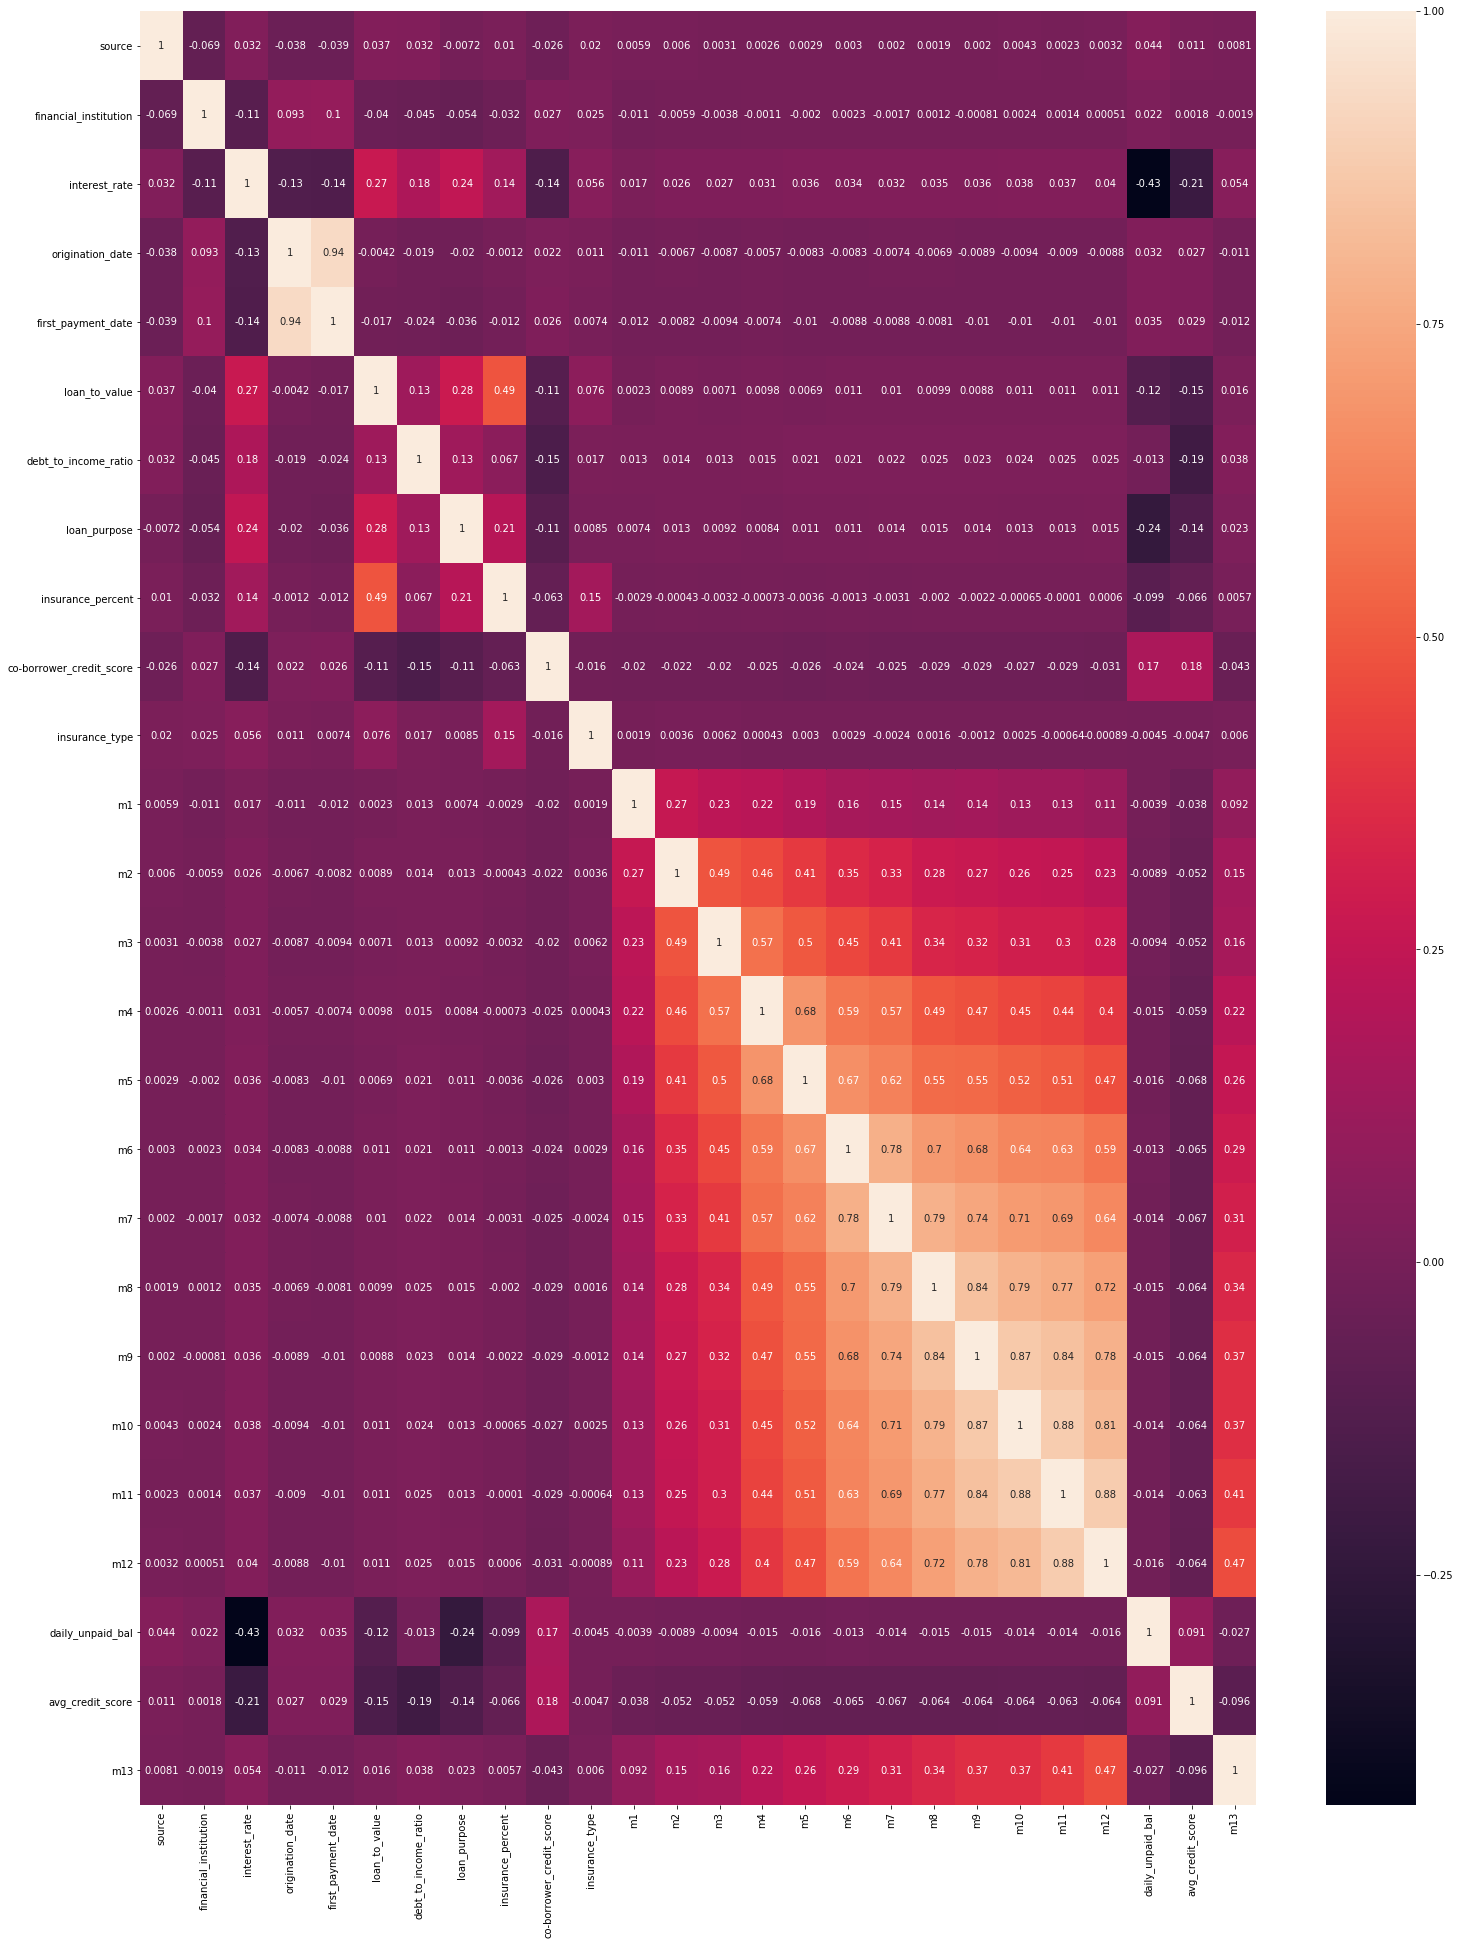

In [10]:
# plot a correlogram of the explanatory features
trainData.plot_corr()

In [11]:
trainData.dropCols(['source','financial_institution','insurance_type','insurance_percent','m1','m2','m3','m4','m5']) 
# we can easily spot some very lowly correlated variables based on above graphs and remove them


 Check target class distribution 

col_0   count    percent
m13                     
0      115422  99.451998
1         636   0.548002


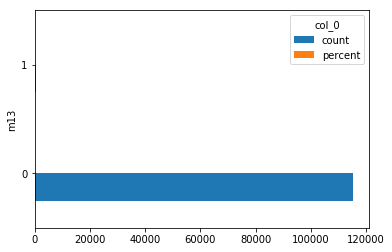

In [12]:
# view class distribution of target, this will affect sampling
trainData.class_dist()

In [13]:
# create final predictors/target after any required resampling(depends on target class distribution)
X,y,model_cols = trainData.create_Xy(imbalance = 'Y')


 No: of predictor variables is: 16 and no:of observations for training is: 230844 



In [15]:
model_cols # view the final set of columns retained

['interest_rate',
 'origination_date',
 'first_payment_date',
 'loan_to_value',
 'debt_to_income_ratio',
 'loan_purpose',
 'co-borrower_credit_score',
 'm6',
 'm7',
 'm8',
 'm9',
 'm10',
 'm11',
 'm12',
 'daily_unpaid_bal',
 'avg_credit_score']

<font color='blue'><b>Train a <font color = 'red'> Neural Network classifer(optional) </font> and a few <i>other classifiers</i> on the training data and keep the most accurate</b></font>

In [17]:
SEED=42
# initialize and train several classifiers and check their cross validated AUC scores achieved

classifiers = [  
    #GaussianNB(),    
    #KNeighborsClassifier(n_neighbors =17,n_jobs =-1)
    #SVC() 
    #XGBClassifier(n_jobs = -1,random_state=SEED),        
    #RandomForestClassifier(n_estimators=10,random_state=SEED,n_jobs =-1,class_weight='balanced'),      
    #LogisticRegression(solver='sag',random_state=SEED),    
    ExtraTreesClassifier(n_estimators=25,random_state=SEED,n_jobs =-1,class_weight='balanced')    
    
]
max_F1_score = 0.0
# iterate over classifiers
for item in classifiers:
    classifier_name = ((str(item)[:(str(item).find("("))]))
    print (classifier_name)
    
    # Create classifier, train it and test it.
    clf = item  
    start_time = timeit.default_timer()   
       
    # calculate, compare and store the most accurate classifier model
    
    curr_F1_score,curr_best_model = F1_score(clf,X,y)
    print ("\nF1 score: ", round(curr_F1_score, 3), "\n- - - - - ", "\n")
    if curr_F1_score>max_F1_score:
        max_F1_score = curr_F1_score
        best_clf = curr_best_model
        best_clfname = classifier_name    
    print('Elapsed Training Time approx :{} minutes'.format((timeit.default_timer() - start_time)/60))
print('\n Best classifier found was : \n',best_clf)
print('\n Best score was : \n',max_F1_score)

ExtraTreesClassifier

 F1 score for CV fold no:1 was:0.998353977197334


 F1 score for CV fold no:2 was:0.9975742815483504


 F1 score for CV fold no:3 was:0.9978339910704133


 F1 score for CV fold no:4 was:0.9976173890641048


 F1 score for CV fold no:5 was:0.9972275049072497


 F1 score for CV fold no:6 was:0.9976173890641048


 F1 score for CV fold no:7 was:0.9979639540477496


 F1 score for CV fold no:8 was:0.9978339910704133


 F1 score for CV fold no:9 was:0.998050592808444


 F1 score for CV fold no:10 was:0.9975307461085322


F1 score:  0.998 
- - - - -  

Elapsed Training Time approx :1.4738097883333325 minutes

 Best classifier found was : 
 ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_job

> Stage 2: <b> <font color = 'blue'>Load and predict labels on Test data </font></b>

In [18]:
# predict classes and store in a column called 'm13'
testData.setTargetCol(target_col)

if best_clfname == 'neural_network':     
    testData.addTgtColNN(best_clf,model_cols)
else:
    testData.addTgtCol(best_clf,model_cols)

#write the output file to disk
outfilename = 'application_test_predict.csv'
testData.PrintCSV(outfilename)


 Prediction file written to disk 

